<a href="https://colab.research.google.com/github/IAmNelu/MLDL/blob/master/ProjectMLDL_PRETEXT_V7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain Adaptation Project

##Prepare Dataset

Run Mount Drive then Copy 1


Mount

In [0]:
#  from google.colab import drive
#  drive.mount('/content/drive')

Copy 1

In [0]:
# !cp /content/drive/My\ Drive/synROD.zip /content/synROD.zip
# !cp /content/drive/My\ Drive/ROD.zip /content/ROD.zip
# !unzip synROD.zip
# !unzip ROD.zip
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1U0WobVS9A36UVEMcEK4YISHRqeDvFW78' -O rod-split_sync.txt
# #  !mv /content/synROD/bell_papper /content/synROD/bell_pepper

##Imports

In [0]:
from sklearn.model_selection import train_test_split
from torchvision.transforms import functional as F
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import VisionDataset
from torchvision.models import resnet18
from collections import OrderedDict
from torch.autograd import Function
from torchvision import transforms
from torch.backends import cudnn
import torch.nn.functional as Fu
from scipy import stats
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np

import torchvision
import numbers
import logging
import os.path
import random
import torch
import errno
import copy
import time
import sys
import os

##Functions & Classes

###Dataset

####Functions


In [0]:
def pil_loader(path):
  with open(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('RGB')

In [0]:
def rotate_image(image, t1, t2, t3, transform):

  rotation = random.randint(0,3)
  if rotation == 0:
    image = transform(image)
    return image, rotation

  elif rotation == 1: #90°
    image_rotate = t3(image)
    image_rotate = transform(image_rotate)
    return image_rotate, rotation

  elif rotation == 2: #180°
    image_rotate = t2(image)
    image_rotate = transform(image_rotate)
    return image_rotate, rotation

  elif rotation == 3: #270°
    image_rotate = t1(image)
    image_rotate = transform(image_rotate)
    return image_rotate, rotation


In [0]:
def initialize_dictionary(path_file, ROD=False): #to check bell papper / pepper and the /n
  dictionary = {}
  reverse_dictionary = {}
  f = open(path_file, "r")
  
  for line in f:
    path, label_index = line.split(" ")
    if ROD == False:
      label_name = path.split("/")[0]
    else:
      label_name = path.split("/")[1]

    dictionary[int(label_index)] = label_name
    reverse_dictionary[label_name] = int(label_index)

  return dictionary, reverse_dictionary

In [0]:
def reduce_set(dataset, size=30000): #modify

  dictionary = dataset.get_samples_label()
  X = list(dictionary.keys())
  y = list(dictionary.values())

  indexes, _, _, _ = train_test_split(X, y, stratify=y, train_size=size)

  return indexes

####ROD


In [0]:
class ROD(VisionDataset):
  def __init__(self, root=None, file_path=None, validation=False, pretext=False, transform=None, target_transform=None):
    super(ROD, self).__init__(root, transform=transform, target_transform=target_transform)

    if file_path == None:
      print("miss the path of the file!")

    if root == None:
      print("miss the path of the dataset!")
      
    #rotation
    self.t1 = transforms.RandomRotation(degrees=[90, 90])
    self.t2 = transforms.RandomRotation(degrees=[180, 180])
    self.t3 = transforms.RandomRotation(degrees=[270, 270])
  
    self.samples_rgb = {}    #dictionary image_index -> path of the image
    self.samples_depth = {}  #dictionary image_index -> path of the image
    self.samples_label = {}  #dictionary image_index -> index of the label
    self.labels_index = {}   #dictionary label_index -> name of the label
    self.labels_name = {}    #dictionary label_names -> index of the label

    self.labels_index, self.labels_name = initialize_dictionary(file_path, ROD=True) 
    self.pretext = pretext
    self.validation = validation


    # Read files and load images in memory  
    idx = 0       #actual number of image
    f = open(file_path, "r")
    for line in f:
      path, label = line.split(" ")

      rgb_path = path.replace("???","rgb",1)
      rgb_path = rgb_path.replace("***","crop",1)
      self.samples_rgb[idx] = pil_loader(root+"/"+rgb_path)

      depth_path = path.replace("???","surfnorm",1)
      depth_path = depth_path.replace("***","depthcrop",1)
      self.samples_depth[idx] = pil_loader(root+"/"+depth_path)

      self.samples_label[idx] = int(label)
      idx += 1

   
  def __getitem__(self, index):
    image_rgb = self.samples_rgb.get(index)
    image_depth = self.samples_depth.get(index)

    if self.validation: # if validation is true, target transformations are applied
      image_rgb = self.target_transform(image_rgb)
      image_depth = self.target_transform(image_depth)

      label = self.samples_label.get(index)
      return [image_rgb, image_depth], label

    image_rgb = self.transform[0](image_rgb) #resize
    image_depth = self.transform[0](image_depth)

    image_rgb, image_depth = self.transform[1][0](image_rgb, image_depth) # Random Crop
    image_rgb, image_depth = self.transform[1][1](image_rgb, image_depth) # Horizontal flip

    if not self.pretext: 
      image_rgb = self.transform[2](image_rgb) # To Tensor & Normlize 
      image_depth = self.transform[2](image_depth)

      label = self.samples_label.get(index)
      
      return [image_rgb, image_depth], label

    else: # rotate the image
      image_rgb, rotation_rgb = rotate_image(image_rgb, self.t1, self.t2, self.t3, self.transform[2]) #Rotation RGB
      image_depth, rotation_depth = rotate_image(image_depth, self.t1, self.t2, self.t3, self.transform[2]) #Rotation Depth
      
      if rotation_rgb > rotation_depth:  # encoding relative rotation from rgb to depth
        relative_rotation = 4 - rotation_rgb + rotation_depth
      elif rotation_rgb < rotation_depth:
        relative_rotation = rotation_depth - rotation_rgb
      else:
        relative_rotation = 0  

      return [image_rgb, image_depth], relative_rotation


  def __len__(self):
    length = len(self.samples_rgb)
    return length 

  def get_labels_dictionary(self):
    return self.labels_index, self.labels_name

  def get_samples_label(self):
    return self.samples_label

  def set_pretext(self, pretext):
    self.pretext = pretext

  def set_validation(self, validation):
    self.validation = validation

####synROD


In [0]:
class synROD(VisionDataset): 
  def __init__(self, root=None, file_path=None, pretext=False, transform=None, target_transform=None):
    super(synROD, self).__init__(root, transform=transform, target_transform=target_transform)

    if file_path == None:
      print("miss the path of the file!")

    if root == None:
      print("miss the path of the dataset!")
    
    #rotation
    self.t1 = transforms.RandomRotation(degrees=[90, 90])
    self.t2 = transforms.RandomRotation(degrees=[180, 180])
    self.t3 = transforms.RandomRotation(degrees=[270, 270])
  
    self.samples_rgb = {}    #dictionary image_index -> path of the image
    self.samples_depth = {}  #dictionary image_index -> path of the image
    self.samples_label = {}  #dictionary image_index -> index of the label
    self.labels_index = {}   #dictionary label_index -> name of the label
    self.labels_name = {}    #dictionary label_names -> index of the label

    self.labels_index, self.labels_name = initialize_dictionary(file_path)
 
    self.pretext = pretext
    
    # Read files and load path in memory  
    idx = 0                  #actual number of images   
    f = open(file_path, "r")

    for line in f:
      path, label = line.split(" ")
      
      rgb_path = path.replace("***","rgb",1)
      self.samples_rgb[idx] = root+"/"+rgb_path
      
      depth_path = path.replace("***","depth",1)
      self.samples_depth[idx] = root+"/"+depth_path

      self.samples_label[idx] = int(label)
      idx += 1

  def __getitem__(self, index):
    path_rgb = self.samples_rgb.get(index)
    image_rgb = pil_loader(path_rgb)
    image_rgb = self.transform[0](image_rgb) 

    path_depth = self.samples_depth.get(index)
    image_depth = pil_loader(path_depth)
    image_depth = self.transform[0](image_depth)

    image_rgb, image_depth = self.transform[1][0](image_rgb, image_depth) # Random Crop
    image_rgb, image_depth = self.transform[1][1](image_rgb, image_depth) # Horizontal flip

    if not self.pretext:
      image_rgb = self.transform[2](image_rgb)
      image_depth = self.transform[2](image_depth)

      label = self.samples_label.get(index)
      
      return [image_rgb, image_depth], label

    else:
      image_rgb, rotation_rgb = rotate_image(image_rgb, self.t1, self.t2, self.t3, self.transform[2])
      image_depth, rotation_depth = rotate_image(image_depth, self.t1, self.t2, self.t3, self.transform[2])

      if rotation_rgb > rotation_depth:  # encoding relative rotation from rgb to depth
        relative_rotation = 4 - rotation_rgb + rotation_depth
      elif rotation_rgb < rotation_depth:
        relative_rotation = rotation_depth - rotation_rgb
      else:
        relative_rotation = 0  

      return [image_rgb, image_depth], relative_rotation


  def __len__(self):
    length = len(self.samples_rgb)
    return length 

  def get_labels_dictionary(self):
    return self.labels_index, self.labels_name

  def get_samples_label(self):
    return self.samples_label

  def set_pretext(self, pretext):
    self.pretext = pretext

### Network 

####Helping Blocks

In [0]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
  """3x3 convolution with padding"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                   padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
  """1x1 convolution"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
               base_width=64, dilation=1, norm_layer=None):
    super(BasicBlock, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    if groups != 1 or base_width != 64:
      raise ValueError('BasicBlock only supports groups=1 and base_width=64')
    if dilation > 1:
      raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
    # Both self.conv1 and self.downsample layers downsample the input when stride != 1
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = norm_layer(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = norm_layer(planes)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)
    return out

####MagicNet

In [0]:
class MagicNet(nn.Module):

  def __init__(self, block, layers, complete=True, num_classes=1000, zero_init_residual=False,
                groups=1, width_per_group=64, replace_stride_with_dilation=None,
                norm_layer=None):
    super(MagicNet, self).__init__()
    if norm_layer is None:
        norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer

    self.complete = complete
    self.inplanes = 64
    self.dilation = 1
    if replace_stride_with_dilation is None:
        # each element in the tuple indicates if we should replace
        # the 2x2 stride with a dilated convolution instead
        replace_stride_with_dilation = [False, False, False]
    if len(replace_stride_with_dilation) != 3:
        raise ValueError("replace_stride_with_dilation should be None or a 3-element tuple, got {}".format(replace_stride_with_dilation))
    self.groups = groups
    self.base_width = width_per_group
    # CODA Ec
    # First layer 7x7, 64 neurons stride 2
    self.conv1_c = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1_c = norm_layer(self.inplanes)
    self.relu_c = nn.ReLU(inplace=True)
    self.maxpool_c = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1_c = self._make_layer(block, 64, layers[0])  # Conv 2_2 output 56x56, 128
    self.layer2_c = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])  # Conv 3_2 28x28, 256
    self.layer3_c = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])  # Conv 4_2 14x14, 512
    self.layer4_c = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])  # Conv 5_2 7x7, 1024
    self.inplanes = 64  # reset inplanes number
    # CODA Ed
    # First layer 7x7, 64 neurons stride 2
    self.conv1_d = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1_d = norm_layer(self.inplanes)
    self.relu_d = nn.ReLU(inplace=True)
    self.maxpool_d = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1_d = self._make_layer(block, 64, layers[0])  # Conv 2_2 output 56x56, 128
    self.layer2_d = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])  # Conv 3_2 28x28, 256
    self.layer3_d = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])  # Conv 4_2 14x14, 512
    self.layer4_d = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])  # Conv 5_2 7x7, 1024

    multiplier = 1
    if  complete:
      multiplier = 2
    
    # Head M
    self.main_head = nn.Sequential(OrderedDict([
        ('avgpool_m',   nn.AdaptiveAvgPool2d((1, 1))), # https://discuss.pytorch.org/t/adaptive-avg-pool2d-vs-avg-pool2d/27011
        ('flatten',     nn.Flatten(1)),
        ('fc_m1000',    nn.Linear(512 * block.expansion * multiplier, 1000)),# multiplied by 2: 512 for RGB and 512 for depth
        ('normal_m',    nn.BatchNorm1d(1000)),
        ('relu_mfc',    nn.ReLU(inplace=True)),
        ('drop_m1000',  nn.Dropout()),
        ('fc_mC',       nn.Linear(1000, num_classes)),
    ]))


    # Head P
    self.pretext_head = nn.Sequential(OrderedDict([
        ('conv1_p',     nn.Conv2d(512*multiplier, 100, kernel_size=1,stride=1)),
        ('normal_pcv1', nn.BatchNorm2d(100)),
        ('relu_pc1',    nn.ReLU(inplace=True)),
        ('conv2_p',     nn.Conv2d(100, 100, kernel_size=3,stride=2)),
        ('normal_pcv2', nn.BatchNorm2d(100)),
        ('relu_pc2',    nn.ReLU(inplace=True)),
        ('flatten',     nn.Flatten(1)),
        ('fc_p100',     nn.Linear(900, 100)),
        ('normal_pfc',  nn.BatchNorm1d(100)),
        ('relu_pfc',    nn.ReLU(inplace=True)),
        ('drop_p100',   nn.Dropout()),
        ('fc_p4',       nn.Linear(100, 4)),
    ]))

    # ### ERASE since values are overwritten ##############################################
    # for m in self.modules():
    #   if isinstance(m, nn.Conv2d):
    #     # Fills the input Tensor with values according to the method described in “Delving deep into rectifiers: Surpassing human-level
    #     # performance on ImageNet classification” - He, K. et al. (2015), using a normal distribution. Also known as He initialization.
    #     # No gradient will be recorded for this operation.
    #     nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    #   elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
    #     # Fills the given tensor with the provided value in-place, and returns it.
    #     # No gradient will be recorded for this operation.
    #     nn.init.constant_(m.weight, 1)
    #     nn.init.constant_(m.bias, 0)
    #   ##############################################

  def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
    norm_layer = self._norm_layer
    downsample = None
    previous_dilation = self.dilation
    if dilate:
      self.dilation *= stride
      stride = 1
    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = nn.Sequential(
          conv1x1(self.inplanes, planes * block.expansion, stride),
          norm_layer(planes * block.expansion),
      )

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                        self.base_width, previous_dilation, norm_layer))
    self.inplanes = planes * block.expansion
    for _ in range(1, blocks):
      layers.append(block(self.inplanes, planes, groups=self.groups,
                          base_width=self.base_width, dilation=self.dilation,
                          norm_layer=norm_layer))

    return nn.Sequential(*layers)

  def _forward_impl(self, rgb_x=None, dp_x=None, main_task=True): # passare spezzati 
    
    rgb_x = self.conv1_c(rgb_x)
    rgb_x = self.bn1_c(rgb_x)
    rgb_x = self.relu_c(rgb_x)
    rgb_x = self.maxpool_c(rgb_x)

    rgb_x = self.layer1_c(rgb_x)
    rgb_x = self.layer2_c(rgb_x)
    rgb_x = self.layer3_c(rgb_x)
    rgb_x = self.layer4_c(rgb_x)


    dp_x = self.conv1_d(dp_x)
    dp_x = self.bn1_d(dp_x)
    dp_x = self.relu_d(dp_x)
    dp_x = self.maxpool_d(dp_x)

    dp_x = self.layer1_d(dp_x)
    dp_x = self.layer2_d(dp_x)
    dp_x = self.layer3_d(dp_x)
    dp_x = self.layer4_d(dp_x)

    d_rgb_x = torch.cat((dp_x, rgb_x), 1)  #concatenation

    if main_task:
      d_rgb_x = self.main_head(d_rgb_x)
    else:
      d_rgb_x = self.pretext_head(d_rgb_x)
    return d_rgb_x

  def forward(self, rgb_x=None, dp_x=None, main_task=True):
    return self._forward_impl(rgb_x=rgb_x, dp_x=dp_x, main_task=main_task)

  def initNet(self):
    netSource = resnet18(pretrained=True)
    # copy Ec
    self.conv1_c.weight.data = copy.deepcopy(netSource.conv1.weight.data)
    # self.conv1_c.bias.data = copy.deepcopy(netSource.conv1.bias.data)
    self.bn1_c.weight.data = copy.deepcopy(netSource.bn1.weight.data)
    self.bn1_c.bias.data = copy.deepcopy(netSource.bn1.bias.data)
    self.layer1_c = copy.deepcopy(netSource.layer1)
    self.layer2_c = copy.deepcopy(netSource.layer2)
    self.layer3_c = copy.deepcopy(netSource.layer3)
    self.layer4_c = copy.deepcopy(netSource.layer4)
    # copy Ed
    self.conv1_d.weight.data = copy.deepcopy(netSource.conv1.weight.data)
    # self.conv1_d.bias.data = copy.deepcopy(netSource.conv1.bias.data)
    self.bn1_d.weight.data = copy.deepcopy(netSource.bn1.weight.data)
    self.bn1_d.bias.data = copy.deepcopy(netSource.bn1.bias.data)
    self.layer1_d = copy.deepcopy(netSource.layer1)
    self.layer2_d = copy.deepcopy(netSource.layer2)
    self.layer3_d = copy.deepcopy(netSource.layer3)
    self.layer4_d = copy.deepcopy(netSource.layer4)

    for module in self.main_head:
      if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data, gain=nn.init.calculate_gain('relu'))
        if not module.bias.data is None:
            module.bias.data.zero_()
    for module in self.pretext_head:
      if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data, gain=nn.init.calculate_gain('relu'))
        if not module.bias.data is None:
            module.bias.data.zero_()

  def load_state_from_file(self, file_name):
    if os.path.isfile(file_name):
      self.load_state_dict(torch.load(file_name))
      print(f'Model {file_name} loaded succesfully')
    else:
      raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), file_name)

  def save_state_on_file(self, file_name):
    torch.save(self.state_dict(), file_name)
    print(f'Model saved succesfully on file {file_name}')
      
def _magicnet(block, pretrained, complete, **kwargs):
  model = MagicNet(block, [2, 2, 2, 2], complete=complete, **kwargs)
  if pretrained:
    if os.path.isfile('magic_net.pth'):
      model.load_state_dict(torch.load("magic_net.pth"))
    else:
      model.initNet()
      torch.save(model.state_dict(), 'magic_net.pth')
  return model


def magicnet(pretrained=False, complete=True, **kwargs): # Complete uses both rgb and depth
  return _magicnet(BasicBlock, pretrained, complete=complete, **kwargs)

###Utility

In [0]:
def entropy_loss(logits):
    p_softmax = Fu.softmax(logits, dim=1)
    mask = p_softmax.ge(0.000001)  # greater or equal to, used for numerical stability
    mask_out = torch.masked_select(p_softmax, mask)
    entropy = -(torch.sum(mask_out * torch.log(mask_out)))
    return entropy / float(p_softmax.size(0))

In [0]:
def getTimes(start_s, end_s, for_what='test'):
  time_taken = end_s - start_s
  seconds = int(time_taken%60)
  time_taken -= seconds
  minutes = int(time_taken/60)
  ores = int(minutes/60)
  minutes %= 60
  minutes = int(minutes)
  ores_s = str(ores)
  minutes_s = str(minutes)
  seconds_s = str(seconds)
  if ores < 10:
    ores_s = '0' + ores_s
  if minutes < 10:
    minutes_s = '0' + minutes_s
  if seconds < 10:
    seconds_s = '0' + seconds_s
  print(f'Time taken for {for_what}: {ores_s}:{minutes_s}:{seconds_s}')
  return f'{ores_s}:{minutes_s}:{seconds_s}'

In [0]:
def plot_losses(losses, sampling_size=10, labels=['Main Task Loss', 'Entropy Loss ROD','synROD Pretext Task', 'ROD Pretext Task'], 
                colors=['#2AC213','#0A5DC2','#C23094','#C2810A'], fig_size=(10,7), 
                        legend_pos=(0.74,0.99), save_to_png=False, title='Loss', x_label='Step #', y_label='Loss'):
  x = np.arange(len(losses[0]))
  fig = plt.figure(figsize=fig_size)
  ax = fig.add_subplot(111)
  print(len(losses))
  for i, y in enumerate(losses):
    if len(y) > 0:
      ax.plot(x[::sampling_size], y[::sampling_size], linestyle='-',  marker="h", c=colors[i], label=labels[i])
  ax.plot(x, [min(losses[0])]*len(losses[0]), c='r', linestyle='--',  marker="", label=f'Min Loss {min(losses[0]):.2f}')
  plt.legend(bbox_to_anchor=legend_pos, loc='upper left', borderaxespad=0.)
  
  plt.grid(color='w')
  # plt.ylim(0)
  ax.set_axisbelow(True)
  ax.set_facecolor('#EAEAF2')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  ax.yaxis.grid('Ture')
  plt.title(title, fontsize=25)
  if save_to_png:
    plt.savefig(f"{title}.png", dpi=240)
  else:
    plt.show()
  return

In [0]:
def plot_accuracies(accuracies, test_accuracy=None, sampling_size=1, 
                  labels=['Validation Accuracies', 'Test Accuracy'], 
                  colors=['#7C55BD','#42BD5B'], fig_size=(10,7), 
                          legend_pos=(0.74,0.99), save_to_png=False, 
                          title='Accuracies in %', x_label='Epochs', y_label='Accuracy'):
  x = np.arange(len(accuracies))
  fig = plt.figure(figsize=fig_size)
  ax = fig.add_subplot(111)

  ax.plot(x[::sampling_size], accuracies[::sampling_size], linestyle='-',  marker="h", c=colors[0], label=labels[0])
  if not test_accuracy is None:
    ax.plot(x, [test_accuracy]*len(accuracies), c=colors[1], linestyle='-',  marker="", label=labels[1])
  ax.plot(x, [max(accuracies)]*len(accuracies), c='r', linestyle='--',  marker="", label=f'Max Accuracy {max(accuracies):.2f}%')
  plt.legend(bbox_to_anchor=legend_pos, loc='upper left', borderaxespad=0.)
  
  plt.grid(color='w')
  # plt.ylim(0)
  ax.set_axisbelow(True)
  ax.set_facecolor('#EAEAF2')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  ax.yaxis.grid('Ture')
  plt.title(title, fontsize=25)
  if save_to_png:
    plt.savefig(f"{title}.png", dpi=240)
  else:
    plt.show()
  return

In [0]:
def stop_trining_4(array_of_validations):
  if len(array_of_validations) < 4:
    return False
  if array_of_validations[-1] < array_of_validations[-2] < array_of_validations[-3] < array_of_validations[-4]:
    return True
  return False

def stop_trining_3(array_of_validations):
  if len(array_of_validations) < 3:
    return False
  if array_of_validations[-1] < array_of_validations[-2] < array_of_validations[-3]:
    return True
  return False
  
def stop_trining_2(array_of_validations):
  if len(array_of_validations) < 2:
    return False
  if array_of_validations[-1] < array_of_validations[-2]:
    return True
  return False

# def stop_schifo(vl, thresh):
#   if val < thresh:
#     return True
#   return False

In [0]:
def read_list(filename):
  if os.path.isfile(filename):
    lista = []
    with open(filename, 'r') as f:
      for row in f:
        lista.append(float(row))
    return lista
  else:
    return []
def write_list(filename, values):
  with open(filename, 'a') as f:
    for val in values:
      f.write(f'{str(val)}\n')

###Validation / test

In [0]:
## Validation
def test_validate(net, valid_dataloader, len_data, DEVICE='cuda', padding_text='A'):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  running_corrects = 0
  for images, labels in tqdm(valid_dataloader):
    labels = labels.to(DEVICE)
    #concatenate RGB and Depth for Syn
    imagesRGB = images[0].to(DEVICE)
    imagesD = images[1].to(DEVICE)

    # Forward Pass
    outputs = net(rgb_x=imagesRGB, dp_x=imagesD)
    
    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len_data)

  print(f'{padding_text}ccuracy: {accuracy*100:.2f}%')
  net.train(True)
  return accuracy * 100

##Train

###Prepare Train

#####Set Parameters

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 47 # da modificare 
BATCH_SIZE = 32      
LR = 3e-4            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.05
NUM_EPOCHS = 10      # Total number of training epochs (iterations over dataset)

ALPHA = 1
ENTROPY_LOSS_WEIGHT=0.1
LOG_FREQUENCY = 100
VALIDATION_SIZE = BATCH_SIZE * 100

####Transformation

In [0]:
class RandomCrop(object):
  def __init__(self, size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):
    if isinstance(size, numbers.Number):
      self.size = (int(size), int(size))
    else:
      self.size = size
    self.padding = padding
    self.pad_if_needed = pad_if_needed
    self.fill = fill
    self.padding_mode = padding_mode

  @staticmethod
  def get_params(img, output_size):
    # w, h = _get_image_size(img)
    w, h = img.size
    th, tw = output_size
    if w == tw and h == th:
      return 0, 0, h, w

    i = random.randint(0, h - th)
    j = random.randint(0, w - tw)
    return i, j, th, tw

  def __call__(self, img1, img2):
    
    if self.padding is not None:
      img1 = F.pad(img1, self.padding, self.fill, self.padding_mode)
      img2 = F.pad(img2, self.padding, self.fill, self.padding_mode)

    # pad the width if needed (img1)
    if self.pad_if_needed and img1.size[0] < self.size[1]:
      img1 = F.pad(img1, (self.size[1] - img1.size[0], 0), self.fill, self.padding_mode)

    # pad the height if needed (img 1)
    if self.pad_if_needed and img1.size[1] < self.size[0]:
      img1 = F.pad(img1, (0, self.size[0] - img1.size[1]), self.fill, self.padding_mode)

      # pad the width if needed (img 2)
    if self.pad_if_needed and img2.size[0] < self.size[1]:
      img2 = F.pad(img2, (self.size[1] - img2.size[0], 0), self.fill, self.padding_mode)

    # pad the height if needed (img 2)
    if self.pad_if_needed and img2.size[1] < self.size[0]:
      img2 = F.pad(img2, (0, self.size[0] - img2.size[1]), self.fill, self.padding_mode)

    i, j, h, w = self.get_params(img1, self.size)

    return F.crop(img1, i, j, h, w), F.crop(img2, i, j, h, w)

  def __repr__(self):
    return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)

In [0]:
class RandomHorizontalFlip(object):
  def __init__(self, p=0.5):
    self.p = p

  def __call__(self, img1, img2):
    if random.random() < self.p:
      return F.hflip(img1), F.hflip(img2)
    return img1, img2

  def __repr__(self):
    return self.__class__.__name__ + '(p={})'.format(self.p)

In [0]:
#set trasformation
train_transform_resize = transforms.Resize(256)
train_transform_pair_image = [RandomCrop(224), RandomHorizontalFlip()] # invertire trasformazione
train_transform_final = transforms.Compose([transforms.ToTensor(), 
                                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]) 

####Load Dataset

In [0]:
DIR_synROD ="synROD"
DIR_ROD = "ROD"
synROD_train_split = "/content/synROD/synARID_50k-split_sync_train1.txt"
synROD_test_split = "/content/synROD/synARID_50k-split_sync_test1.txt"
ROD_split = "/content/rod-split_sync.txt"

In [26]:
synROD_train_dataset = synROD(DIR_synROD,transform=[train_transform_resize, train_transform_pair_image,train_transform_final], file_path=synROD_train_split)
ROD_dataset = ROD(DIR_ROD,transform=[train_transform_resize, train_transform_pair_image,train_transform_final], target_transform=test_transform, file_path=ROD_split)

print(f'synROD train Dataset: {len(synROD_train_dataset)}')
print(f'ROD Dataset: {len(ROD_dataset)}')

indexes = reduce_set(synROD_train_dataset, size=len(ROD_dataset))
synROD_reduced_dataset = Subset(synROD_train_dataset, indexes)
print(f'synROD Dataset: {len(synROD_reduced_dataset)}')

indexes = reduce_set(ROD_dataset, size=VALIDATION_SIZE)
ROD_validation_dataset = Subset(ROD_dataset, indexes)
print(f'ROD validation Dataset: {VALIDATION_SIZE}')

synROD train Dataset: 37528
ROD Dataset: 32476
synROD Dataset: 32476
ROD validation Dataset: 3200


In [0]:
synROD_dataloader = DataLoader(synROD_reduced_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
ROD_dataloader = DataLoader(ROD_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
ROD_dataloader_valid = DataLoader(ROD_validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

synROD_dataloader_r = DataLoader(synROD_reduced_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
ROD_dataloader_r = DataLoader(ROD_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

#### Net & Loss & Optimizer & Scheduler

In [28]:
net = magicnet(pretrained=True, num_classes=NUM_CLASSES)
# Define loss function
criterion_maintask = nn.CrossEntropyLoss()
criterion_pretext_ROD = nn.CrossEntropyLoss()
criterion_pretext_synROD = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters() 

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
reti = []
ottimizzatori = []
epochs_done = 0
loss_syn_c_file = 'loss_syn_c.txt'
loss_syn_p_file = 'loss_syn_p.txt'
loss_rod_c_file = 'loss_rod_c.txt'
loss_rod_p_file = 'loss_rod_p.txt'
validations_file = 'validations.txt'
for file_n in os.listdir():
  if file_n.startswith('magic_ep_'):
    reti.append(file_n)
  elif file_n.startswith('optimizer_ep_'):
    ottimizzatori.appendd(file_n)
  elif file_n.startswith('loss_syn_c'):
    loss_syn_c_file = file_n
  elif file_n.startswith('loss_syn_p'):
    loss_syn_p_file = file_n
  elif file_n.startswith('loss_rod_c'):
    loss_rod_c_file = file_n 
  elif file_n.startswith('loss_rod_p'):
    loss_rod_p_file = file_n
  elif file_n.startswith('validations'):
    validations_file = file_n

if len(reti) != 0:
  epochs_done = int(reti[-1].split('magic_ep_')[-1].split('_')[0])
  net.load_from_file(reti[-1])
  optimizer.load_state_dict(torch.load(ottimizzatori[-1])['optimizer'])

###Train

In [0]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime
p_myloss_clas_syn = []
p_myloss_pretext_syn = []
p_myloss_clas_rod = []
p_myloss_pretext_rod = []
p_validations = read_list(validations_file)
p_current_step = 0
p_best_net = None
best_val = 0
effective_ep = -1

#### Pretext

In [31]:
########################################## PRETEXT: Domain Adaptation 
# Start iterating over the epochs
# synROD_train_dataset.set_pretext(False)
# ROD_dataset.set_pretext(False)

N_BATCH = len(ROD_dataloader)

ask_for_money = time.time()
for epoch in range(epochs_done, NUM_EPOCHS):
  one_day_baby = time.time()
  print(f'Starting epoch {epoch+1}/{NUM_EPOCHS}, LR = {LR}')

  synROD_train_dataset.set_pretext(False)
  ROD_dataset.set_pretext(False)
  synROD_iter = iter(synROD_dataloader)
  ROD_iter = iter(ROD_dataloader)

  synROD_train_dataset.set_pretext(True)
  ROD_dataset.set_pretext(True)
  synROD_iter_r = iter(synROD_dataloader_r)
  ROD_iter_r = iter(ROD_dataloader_r)
  
  for _ in range(N_BATCH):
    net.train(True) # Sets module in training mode

    if p_current_step % 2 == 0:
      optimizer.zero_grad() # Zero-ing the gradients
    
    #MAIN TASK
    #synROD
    images, labels = next(synROD_iter)

    #load on DEVICE label, images RGB and Depth
    label = labels.to(DEVICE)
    imageRGB = images[0].to(DEVICE) #RGB
    imageD = images[1].to(DEVICE)   #Depth

    # Forward pass to the network synROD
    outputs = net(rgb_x=imageRGB, dp_x=imageD) #main_task=True
    loss_main = criterion_maintask(outputs, label)
    p_myloss_clas_syn.append(loss_main.item())
    loss_main.backward(retain_graph=True) #retain_graph to be able to compute again the gradient
      
    #ROD
    images, _ = next(ROD_iter)
    #load on DEVICE images RGB and Depth
    imageRGB = images[0].to(DEVICE)  #RGB
    imageD = images[1].to(DEVICE)    #Depth

    # Forward pass to the network ROD
    outputs = net(rgb_x=imageRGB, dp_x=imageD) #main_task=True
    loss_no_label = entropy_loss(outputs)
    loss_no_label *= ENTROPY_LOSS_WEIGHT

    p_myloss_clas_rod.append(loss_no_label.item()/ENTROPY_LOSS_WEIGHT)
    loss_no_label.backward(retain_graph=True)
        
    #PRETEXT TASK: S and T rotated
    #synROD
    images, labels = next(synROD_iter_r)
    #load on DEVICE labels, images RGB rotated and Depth rotated
    label = labels.to(DEVICE)
    imageRGB = images[0].to(DEVICE) #RGB
    imageD = images[1].to(DEVICE)   #Depth

    outputs = net(rgb_x=imageRGB, dp_x=imageD, main_task=False)

    loss_pretext_synROD = criterion_pretext_synROD(outputs, label)
    # loss_pretext_synROD *= ALPHA
    p_myloss_pretext_syn.append(loss_pretext_synROD.item())#/ALPHA)
    loss_pretext_synROD.backward(retain_graph=True)
    
    #ROD
    images, labels = next(ROD_iter_r)
    #load on DEVICE labels, images RGB rotated and Depth rotated
    label = labels.to(DEVICE)
    imageRGB = images[0].to(DEVICE) #RGB
    imageD = images[1].to(DEVICE)   #Depth

    outputs = net(rgb_x=imageRGB, dp_x=imageD, main_task=False) 

    loss_pretext_ROD = criterion_pretext_ROD(outputs, label)
    # loss_pretext_ROD *= ALPHA
    p_myloss_pretext_rod.append(loss_pretext_ROD.item())#/ALPHA)  
    loss_pretext_ROD.backward(retain_graph=True)  
    
    #Clear Memory
    label = None
    imageRGB = None
    imageD = None

    if p_current_step % 2 == 1:
      optimizer.step()

    if p_current_step % LOG_FREQUENCY == 0:
      print(f'-----------------STEP {p_current_step:6}-----------------')
      print(f'|{"SYN CLASS":10}|{"ROD CLASS":10}|{"PRE S":10}|{"PRE T":10}|')
      print(f'|{loss_main.item():10.4f}|{loss_no_label.item()/ENTROPY_LOSS_WEIGHT:10.4f}|{loss_pretext_synROD.item()/ALPHA:10.4f}|{loss_pretext_ROD.item()/ALPHA:10.4f}|')
      #print(f'---------------------------------------------')
    p_current_step += 1

  ROD_dataset.set_validation(True)
  valid_value = test_validate(net, ROD_dataloader_valid, VALIDATION_SIZE, DEVICE)
  ROD_dataset.set_validation(False)

  if valid_value > best_val:
    best_val = valid_value
    p_best_net = copy.deepcopy(net)
  p_validations.append(valid_value)

  will_be_old_oh_baby = time.time()
  time_ep = getTimes(one_day_baby, will_be_old_oh_baby, 'one EPOCH')
  # Save States
  valid_value_s = f'{valid_value:.2f}'
  valid_value_s = valid_value_s.replace('.', '_')
  net.save_state_on_file(f'magic_ep_{epoch+1}_acc_{valid_value_s}_time_{time_ep}.pth')
  torch.save({ 'optimizer' : optimizer.state_dict()}, f'optimizer_ep_{epoch+1}.pth.tar')
  write_list(loss_syn_c_file, p_myloss_clas_syn)
  write_list(loss_syn_p_file, p_myloss_pretext_syn)
  write_list(loss_rod_c_file, p_myloss_clas_rod)
  write_list(loss_rod_p_file, p_myloss_pretext_rod)
  write_list(validations_file, [valid_value])
  p_myloss_clas_syn = []
  p_myloss_pretext_syn = []
  p_myloss_clas_rod = []
  p_myloss_pretext_rod = []
  if stop_trining_4(p_validations):
    effective_ep = epoch + 1
    print(f'Accuracy scores are degenerating for four consecuive epochs at epoch:{effective_ep}')
    break  
and_get_advice = time.time() 
if effective_ep == -1: 
  effective_ep = NUM_EPOCHS
getTimes(ask_for_money, and_get_advice, f'{effective_ep} EPOCHS')

Starting epoch 1/10, LR = 0.0003
-----------------STEP      0-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    5.6594|    2.4028|    1.7586|    2.2008|
-----------------STEP    100-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    4.1522|    2.5736|    2.2529|    2.0059|
-----------------STEP    200-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    3.1467|    2.4400|    1.8931|    1.9728|
-----------------STEP    300-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    3.1806|    2.2416|    1.6563|    1.3922|
-----------------STEP    400-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    1.8332|    2.1763|    1.5513|    1.7504|
-----------------STEP    500-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    1.7341|    2.0253|    1.4258|    1.3969|
-----------------STEP    600-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    1.6302|    2.0009|    1.4199|    1.2999|
-

100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Accuracy: 42.78%
Time taken for one EPOCH: 00:30:39
Model saved succesfully on file magic_ep_1_acc_42_78_time_00:30:39.pth
Starting epoch 2/10, LR = 0.0003
-----------------STEP   1100-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.5709|    1.5877|    1.1641|    1.0201|
-----------------STEP   1200-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    1.3879|    1.5634|    0.9174|    0.9785|
-----------------STEP   1300-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    1.0137|    1.5979|    0.9901|    0.8522|
-----------------STEP   1400-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.7015|    1.5282|    1.0145|    0.8564|
-----------------STEP   1500-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.7420|    1.0970|    1.1509|    0.9160|
-----------------STEP   1600-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.6649|    1.1864|    0.8866|    0.9615|
----------------

100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Accuracy: 48.25%
Time taken for one EPOCH: 00:30:37
Model saved succesfully on file magic_ep_2_acc_48_25_time_00:30:37.pth
Starting epoch 3/10, LR = 0.0003
-----------------STEP   2100-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.7995|    1.1649|    0.8997|    0.7956|
-----------------STEP   2200-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.8930|    1.2191|    0.9229|    0.8765|
-----------------STEP   2300-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.3176|    1.2100|    0.7693|    0.8489|
-----------------STEP   2400-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.7005|    1.2605|    0.8999|    0.8404|
-----------------STEP   2500-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4450|    1.1975|    0.8515|    0.8193|
-----------------STEP   2600-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.6314|    0.8412|    0.9646|    0.6969|
----------------

100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Accuracy: 49.97%
Time taken for one EPOCH: 00:30:37
Model saved succesfully on file magic_ep_3_acc_49_97_time_00:30:37.pth
Starting epoch 4/10, LR = 0.0003
-----------------STEP   3100-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.9002|    0.9304|    0.7960|    0.5856|
-----------------STEP   3200-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.3394|    1.1985|    0.7609|    0.5959|
-----------------STEP   3300-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.5389|    0.9860|    0.7175|    0.6411|
-----------------STEP   3400-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4370|    1.1974|    0.7158|    0.6370|
-----------------STEP   3500-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4675|    0.6471|    0.6567|    0.6258|
-----------------STEP   3600-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.5184|    0.7986|    0.6955|    0.4730|
----------------

100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Accuracy: 50.53%
Time taken for one EPOCH: 00:30:39
Model saved succesfully on file magic_ep_4_acc_50_53_time_00:30:39.pth
Starting epoch 5/10, LR = 0.0003
-----------------STEP   4100-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.5082|    0.8555|    0.7194|    0.5584|
-----------------STEP   4200-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.5558|    0.9774|    0.6234|    0.3917|
-----------------STEP   4300-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4570|    0.8828|    0.6612|    0.4813|
-----------------STEP   4400-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4259|    1.0613|    0.5396|    0.7224|
-----------------STEP   4500-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.5006|    0.7681|    0.4439|    0.4157|
-----------------STEP   4600-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.3343|    1.0610|    0.5401|    0.4687|
----------------

100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Accuracy: 49.22%
Time taken for one EPOCH: 00:30:47
Model saved succesfully on file magic_ep_5_acc_49_22_time_00:30:47.pth
Starting epoch 6/10, LR = 0.0003
-----------------STEP   5100-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.8495|    0.7612|    0.4848|    0.3361|
-----------------STEP   5200-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4334|    0.7353|    0.6508|    0.3229|
-----------------STEP   5300-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.3833|    1.2203|    0.7545|    0.3026|
-----------------STEP   5400-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.7196|    0.8390|    0.6415|    0.2327|
-----------------STEP   5500-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.6683|    0.7535|    0.4649|    0.3160|
-----------------STEP   5600-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.3911|    0.8190|    0.5481|    0.2467|
----------------

100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Accuracy: 48.78%
Time taken for one EPOCH: 00:30:33
Model saved succesfully on file magic_ep_6_acc_48_78_time_00:30:33.pth
Starting epoch 7/10, LR = 0.0003
-----------------STEP   6100-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.6353|    0.6371|    0.3311|    0.2291|
-----------------STEP   6200-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.2934|    0.9327|    0.4518|    0.2837|
-----------------STEP   6300-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.3005|    0.8471|    0.3851|    0.2370|
-----------------STEP   6400-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.3243|    0.7305|    0.5115|    0.2888|
-----------------STEP   6500-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4018|    0.9591|    0.4105|    0.2212|
-----------------STEP   6600-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.5240|    0.5408|    0.3782|    0.1680|
----------------

100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


Accuracy: 48.91%
Time taken for one EPOCH: 00:30:39
Model saved succesfully on file magic_ep_7_acc_48_91_time_00:30:39.pth
Starting epoch 8/10, LR = 0.0003
-----------------STEP   7100-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.2492|    0.5046|    0.3235|    0.2080|
-----------------STEP   7200-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.3736|    0.7217|    0.3941|    0.1387|
-----------------STEP   7300-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.5935|    0.5284|    0.2967|    0.2166|
-----------------STEP   7400-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.2772|    0.5919|    0.2853|    0.1495|
-----------------STEP   7500-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4403|    0.7632|    0.2274|    0.2215|
-----------------STEP   7600-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4880|    0.4226|    0.3604|    0.1724|
----------------

100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Accuracy: 49.41%
Time taken for one EPOCH: 00:30:40
Model saved succesfully on file magic_ep_8_acc_49_41_time_00:30:40.pth
Starting epoch 9/10, LR = 0.0003
-----------------STEP   8200-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4025|    0.7885|    0.2807|    0.1236|
-----------------STEP   8300-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.2548|    0.4974|    0.2896|    0.0833|
-----------------STEP   8400-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4162|    0.7559|    0.2248|    0.3165|
-----------------STEP   8500-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.2396|    0.7120|    0.3164|    0.0951|
-----------------STEP   8600-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.4638|    0.6605|    0.2466|    0.1351|
-----------------STEP   8700-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.2803|    0.6034|    0.4048|    0.2051|
----------------

100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy: 48.69%
Time taken for one EPOCH: 00:30:41
Model saved succesfully on file magic_ep_9_acc_48_69_time_00:30:41.pth
Starting epoch 10/10, LR = 0.0003
-----------------STEP   9200-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.2775|    0.6088|    0.1999|    0.0558|
-----------------STEP   9300-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.1981|    0.7246|    0.2605|    0.0549|
-----------------STEP   9400-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.3248|    0.7798|    0.1723|    0.0862|
-----------------STEP   9500-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.5101|    0.4437|    0.2098|    0.0918|
-----------------STEP   9600-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.2405|    0.7848|    0.2748|    0.0854|
-----------------STEP   9700-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.5895|    0.9562|    0.3730|    0.1337|
---------------

100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Accuracy: 47.97%
Time taken for one EPOCH: 00:30:42
Model saved succesfully on file magic_ep_10_acc_47_97_time_00:30:42.pth
Time taken for 10 EPOCHS: 05:06:43


'05:06:43'

4


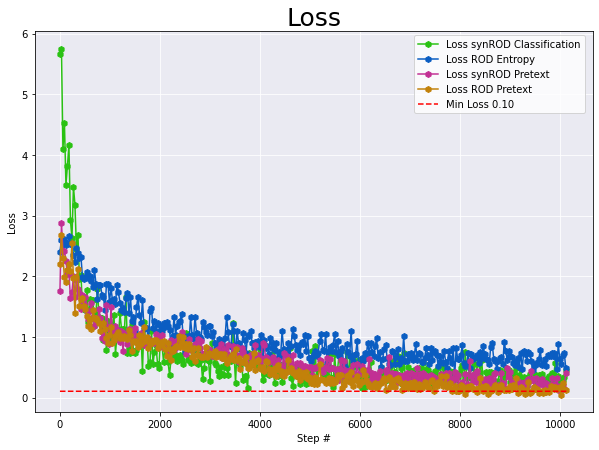

In [36]:
p_myloss_clas_rod = read_list(loss_rod_c_file)
p_myloss_clas_syn = read_list(loss_syn_c_file)
p_myloss_pretext_rod = read_list(loss_rod_p_file)
p_myloss_pretext_syn = read_list(loss_syn_p_file)
plot_losses([p_myloss_clas_syn, p_myloss_clas_rod, p_myloss_pretext_syn, p_myloss_pretext_rod],
            labels=['Loss synROD Classification','Loss ROD Entropy', 'Loss synROD Pretext', 'Loss ROD Pretext'], sampling_size=30,
            legend_pos=(0.68,0.99))

##Test

In [37]:
ROD_dataset.set_validation(True)
p_test_value = test_validate(p_best_net, ROD_dataloader, len(ROD_dataset), DEVICE)

100%|██████████| 1014/1014 [02:59<00:00,  5.64it/s]

Accuracy: 49.36%


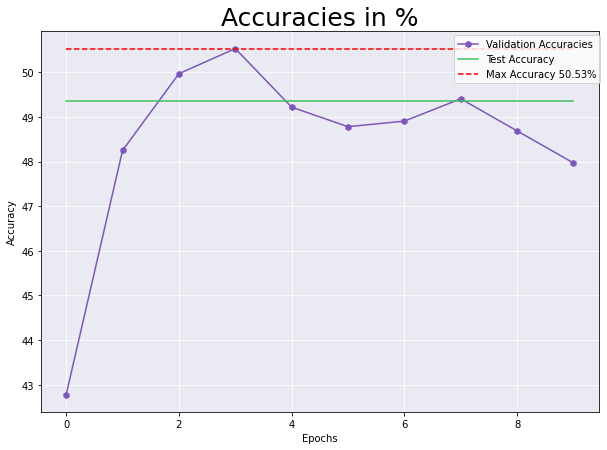

In [38]:
plot_accuracies(p_validations, p_test_value)

In [41]:
#print same summary
steps_per_epochs = int(len(synROD_reduced_dataset) / BATCH_SIZE)
argmax_v = np.argmax(p_validations) + 1
best_step = steps_per_epochs*argmax_v - 1
b_syn_c = p_myloss_clas_syn[best_step]
b_rod_c = p_myloss_clas_rod[best_step]
b_syn_p = p_myloss_pretext_syn[best_step]
b_rod_p = p_myloss_pretext_rod[best_step]
print(f'-------------------- Data for x -------------------')
print(f'|{"Test Acc":8}|{"Best Validation":15}|{"Best Epoch":10}|{"Total Epochs":12}|')
print(f'|{p_test_value:8.5f}|{p_validations[argmax_v]:15.5f}|{argmax_v:10}|{effective_ep:12}|')
print(f'-------------------------.-------------------------')
print(f'-----------------STEP {p_current_step:6}-----------------')
print(f'|{"SYN CLASS":10}|{"ROD CLASS":10}|{"PRE S":10}|{"PRE T":10}|')
print(f'|{b_syn_c:10.4f}|{b_rod_c:10.4f}|{b_syn_p:10.4f}|{b_rod_p:10.4f}|')
print(f'---------------------------------------------')

-------------------- Data for x -------------------
|Test Acc|Best Validation|Best Epoch|Total Epochs|
|49.35645|       49.21875|         4|          10|
-------------------------.-------------------------
-----------------STEP  10140-----------------
|SYN CLASS |ROD CLASS |PRE S     |PRE T     |
|    0.6969|    1.0878|    0.7085|    0.5645|
---------------------------------------------


In [0]:
!cp optimizer* /content/drive/My\ Drive/optimizers